# COVID-19 Logistig function fit
> Fitting logistic functions to COVID-19 growth curve

- comments: true
- author: Caglar Cakan
- categories: [growth, compare]
- permalink: /covid-cases-to-deaths/
- image: images/covid-cases-to-deaths.png

In [1]:
#hide

import numpy as np
from IPython.display import display, Markdown
from IPython.display import HTML

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests
import io
import altair as alt


sns.set_context('talk')
plt.style.use('seaborn-whitegrid')

In [3]:
#hide_input
#HTML(f'<small class="float-right">Last Updated on {pd.to_datetime(LAST_DATE).strftime("%B, %d %Y")}</small>')

In [4]:
#hide

def load_timeseries(name, 
                    base_url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series'):
    import requests
    # Thanks to kasparthommen for the suggestion to directly download
    url = f'{base_url}/time_series_19-covid-{name}.csv'
    csv = requests.get(url).text
    df = pd.read_csv(io.StringIO(csv), 
                     index_col=['Country/Region', 'Province/State', 'Lat', 'Long'])
    df['type'] = name.lower()
    df.columns.name = 'date'

    
    df = (df.set_index('type', append=True)
            .reset_index(['Lat', 'Long'], drop=True)
            .stack()
            .reset_index()
            .set_index('date')
         )
    df.index = pd.to_datetime(df.index)
    df.columns = ['country', 'state', 'type', 'cases']
    
    # Fix South Korea
    df.loc[df.country =='Korea, South', 'country'] = 'South Korea'
    
    # Move HK to country level
    df.loc[df.state =='Hong Kong', 'country'] = 'Hong Kong'
    df.loc[df.state =='Hong Kong', 'state'] = np.nan
    
    # Aggregate large countries split by states
    df = pd.concat([df, 
                    (df.loc[~df.state.isna()]
                     .groupby(['country', 'date', 'type'])
                     .sum()
                     #.rename(index=lambda x: x+' (total)', level=0)
                     .reset_index(level=['country', 'type']))
                   ])  
    
    # Drop states for simplicity
    df = df.loc[df.state.isnull()]
    return df

In [5]:
#hide

def get_countries_with_min_cases_for_df(df_cases, min_cases = 10):
    MIN_CASES = min_cases
    countries = df_cases[df_cases['cases'].ge(MIN_CASES)
           ].sort_values(by='cases', ascending=False)
    countries = countries['country'].values
    return countries

def get_countries_with_min_cases(df_cases, min_cases = 10):
    MIN_CASES = min_cases
    countries = df_cases[df_cases['cases'].ge(MIN_CASES)].sort_values(by='cases', ascending=False)
    countries = countries['country'].unique()
    return countries

def filter_cases(df_cases, min_cases = 10, since_cases=None):
    countries = get_countries_with_min_cases_for_df(df_cases, min_cases)
    if since_cases is None:
        SINCE_CASES_NUM = 100
    else:
        SINCE_CASES_NUM = since_cases
        
    COL_X = f'Days since {SINCE_CASES_NUM}th case'
    dff2 = df_cases[df_cases['country'].isin(countries)].copy()
    dff2['date'] = dff2.index
    days_since = (dff2.assign(F=dff2['cases'].ge(SINCE_CASES_NUM))
                  .set_index('date')
                  .groupby('country')['F'].transform('idxmax'))
    dff2[COL_X] = (dff2['date'] - days_since.values).dt.days.values
    dff2 = dff2[dff2[COL_X].ge(0)]
    return dff2

In [6]:
#hide
from scipy.optimize import curve_fit

def logistic(x, L, k, x0, c):
    #Logistic function
    return (L / (1 + np.exp(-k *(x - x0)))) + c

def fit_country_plot(dff2, str_country, fit_function):
    # str_country = "Germany"
    df_cases_country = dff2[dff2['country']==str_country]
    ydata = df_cases_country.cases.values
    #xdata = range(len(ydata))
    xdata = np.arange(0, len(ydata))
    popt, pcov = curve_fit(fit_function, xdata, ydata, bounds=(0, [1e6, 0.3, 5e1, 1e10]), )
    
    PREDICT_DAYS = 7
    xdata_predicted = range(xdata[-1],xdata[-1]+PREDICT_DAYS)
    y_predicted = logistic(xdata_predicted, *popt)

    #plt.title(str_country)
    plt.plot(xdata, df_cases_country.cases, lw=4, label=str_country, c=get_country_colors(str_country))
    plt.plot(xdata, FIT_FUNCTION(xdata, *popt), c='gray', ls='--', lw=2)
    plt.plot(xdata_predicted, y_predicted, 'k--', lw=2)    
    #plt.legend()
    return popt, pcov

def predict_country(dff2, str_country, fit_function=logistic):
    # str_country = "Germany"
    df_cases_country = dff2[dff2['country']==str_country]
    ydata = df_cases_country.cases.values
    #xdata = range(len(ydata))
    xdata = np.arange(0, len(ydata))
    try:
        popt, pcov = curve_fit(fit_function, xdata, ydata, bounds=(0, [1e6, 0.3, 5e1, 1e10]), )

        PREDICT_DAYS = 7
        xdata_predicted = range(xdata[-1],xdata[-1]+PREDICT_DAYS)
        y_predicted = logistic(xdata_predicted, *popt)

        return xdata_predicted, y_predicted
    except:
        return None, None

In [25]:
#hide
def get_country_colors(x):
    mapping = {
        'Italy': 'black',
        'Iran': '#A1BA59',
        'South Korea': '#E45756',
        'Spain': '#F58518',
        'Germany': '#ba296a',
        'France': '#F58518',
        'US': '#2495D3',
        'Switzerland': '#9D755D',
        'Norway': '#C1B7AD',
        'United Kingdom': '#3250a8',
        'Netherlands': '#7430b3',
        'Sweden': '#C1B7AD',
        'Belgium': '#C1B7AD',
        'Denmark': '#C1B7AD',
        'Austria': '#C1B7AD',
        'Japan': '#9467bd'}
    return mapping.get(x, '#C1B7AD')

In [26]:
#hide
df_cases = load_timeseries("Deaths")
MIN_CASES = 30
SINCE_CASES = 10
dff2 = filter_cases(df_cases, MIN_CASES, SINCE_CASES)

In [27]:
#hide
get_countries_with_min_cases(df_cases, MIN_CASES)

array(['Italy', 'China', 'Iran', 'Spain', 'France', 'US',
       'United Kingdom', 'South Korea', 'Netherlands', 'Germany',
       'Switzerland'], dtype=object)

Italy
China
Iran
Spain
France
US
United Kingdom
South Korea
Netherlands
Germany
Switzerland


Text(0, 0.5, 'Cases')

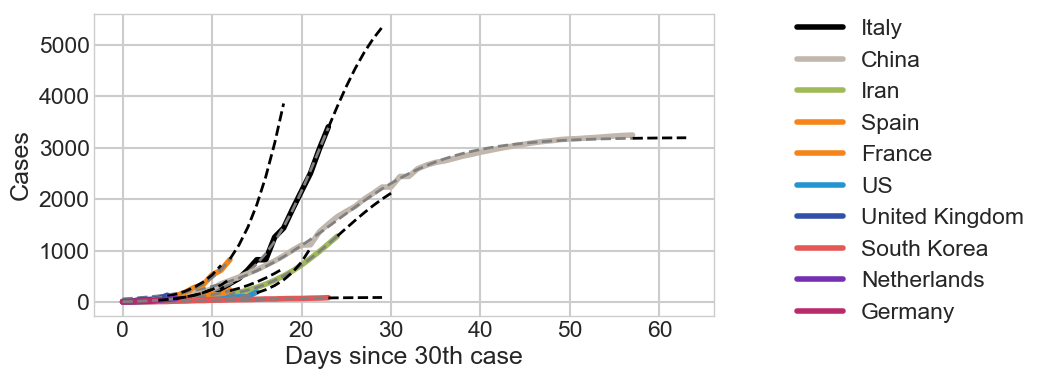

In [28]:
#hide_input
fig, axs = plt.subplots(1, 1, figsize=(8, 4), dpi=100)
FIT_FUNCTION = logistic
ignore = []#["China"]
for str_country in get_countries_with_min_cases(df_cases, MIN_CASES):
    if not str_country in ignore:
        print(str_country)
        try:
            popt, pcov = fit_country_plot(dff2, str_country, FIT_FUNCTION)
        except:
            pass
axs.legend(bbox_to_anchor=(1.1, 1.05))
plt.xlabel(f"Days since {MIN_CASES}th case")
plt.ylabel(f"Cases")

In [29]:
#hide
def make_since_chart(dff2, highlight_countries=[], baseline_countries=[]):
    
    #baseline_countries = ['Italy', 'South Korea', 'Japan']
    max_date = dff2['date'].max()
    color_domain = list(dff2['country'].unique())
    color_range = list(map(get_country_colors, color_domain))


    selection = alt.selection_multi(fields=['country'], bind='legend', 
                                    init=[{'country': x} for x in highlight_countries + baseline_countries])
    
    COL_X = f'Days since {SINCE_CASES}th case'
    base = alt.Chart(dff2, width=550).encode(
        x=f'{COL_X}:Q',
        y=alt.Y('cases:Q', scale=alt.Scale(type='log'), axis=alt.Axis(title='Cumulative Cases')),
        color=alt.Color('country:N', scale=alt.Scale(domain=color_domain)),
        tooltip=list(dff2),
        opacity=alt.condition(selection, alt.value(1), alt.value(0.2))
    )
    
    # prediction of fit -----------
    
    for i, str_country in enumerate(dff2.country.unique()):
        xs, predicted = predict_country(dff2, str_country)
        if xs is None:
            continue
        pred = pd.DataFrame([[x, predicted[i]] for i, x in enumerate(xs)], columns=[COL_X, 'cases'])
        pred['country'] = str_country
        #print(pred)
        if i == 0:
            pred_concat = pred
        else:
            pred_concat = pd.concat([pred_concat, pred], ignore_index=True, axis=0)
    #pred_concat = pred_concat.sort_values(by=['country'])
    print(pred_concat)
    pred = pred_concat
    base_pred = alt.Chart(pred).encode(x=f'{COL_X}:Q', y=f'cases:Q',
                                      color=alt.Color('country:N', scale=alt.Scale(domain=color_domain, range=color_range)),)
    
    # 33% growth reference -----------
    max_day = pred[COL_X].max()
    ref = pd.DataFrame([[x, SINCE_CASES*1.33**x] for x in range(max_day+1)], columns=[COL_X, 'Confirmed Cases'])
    base_ref = alt.Chart(ref).encode(x=f'{COL_X}:Q', y='Confirmed Cases:Q')
    
    return (
        base_ref.mark_line(color='black', opacity=.5, strokeDash=[3,3]) +
        base_ref.transform_filter(
            alt.datum[COL_X] >= max_day
        ).mark_text(dy=-6, align='right', fontSize=10, text='33% Daily Growth') +
        
        base.mark_line(point=True).add_selection(selection) + 
        base.transform_filter(
            alt.datum['date'] >= int(max_date.timestamp() * 1000)
        ).mark_text(dy=-8, align='right', fontWeight='bold').encode(text='country:N') +
        
        base_pred.mark_line(point=True, strokeDash=[3,3]
                           ).transform_filter(selection)
        
    ).properties(
        title=f"{', '.join(highlight_countries)} cases"
    )

In [30]:
#hide_input
chart = make_since_chart(dff2[dff2.country != "China"], ["Germany"],  ['Italy', 'Spain', 'United'])
chart

    Days since 10th case       cases         country
0                      4   41.849156         Germany
1                      5   56.486504         Germany
2                      6   76.241614         Germany
3                      7  102.902313         Germany
4                      8  138.879728         Germany
..                   ...         ...             ...
58                     7  216.220404  United Kingdom
59                     8  291.844940  United Kingdom
60                     9  393.909243  United Kingdom
61                    10  531.648593  United Kingdom
62                    11  717.517076  United Kingdom

[63 rows x 3 columns]


alt.LayerChart(...)